In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label
        # grad represents the derivative of the output with respect to this value
        self.grad = 0.0  # zero by default

        # internal variables used for autograd graph construction
        self._backward = lambda: None # this is a function that will perform the chain rule, by default does nothing, say for a leaf node
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __add__(self, other):  # self + other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward  # store this in a closure
        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):  # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):  # other * self
        """A fallback, if python cannot do 2 * a, 2.__mul__(a),
        then will try a.__rmul__(2)
        """
        return self * other
    
    def __pow__(self, other):  # raise a value to some constant
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _backward
        return out
    
    def __truediv__(self, other):  # self / other
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            # derivative of e^x is e^x
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        # topological order is laying out the nodes so that all the edges go only one way from left to right
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [3]:
from graphviz import Digraph

def trace(root):
    """this function traces the nodes in a graph startinga the root

    Args:
        root (Value): root node

    Returns:
        nodes: set of nodes of the graph
        edges: set of edges of the graph, represented as tuples
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    # Add nodes and edges to the graph object using its node() and edge() or edges() methods

    for n in nodes:
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # and connect this node to it
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

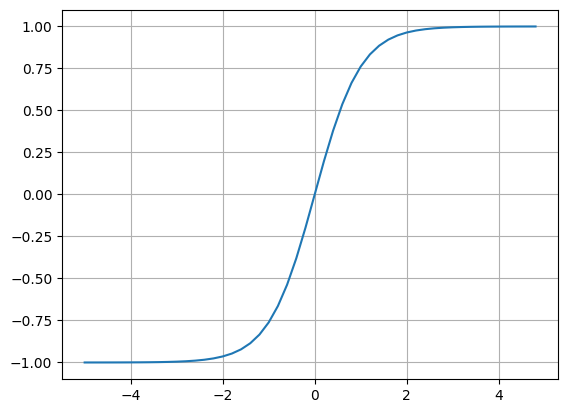

In [4]:
# the tanh function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

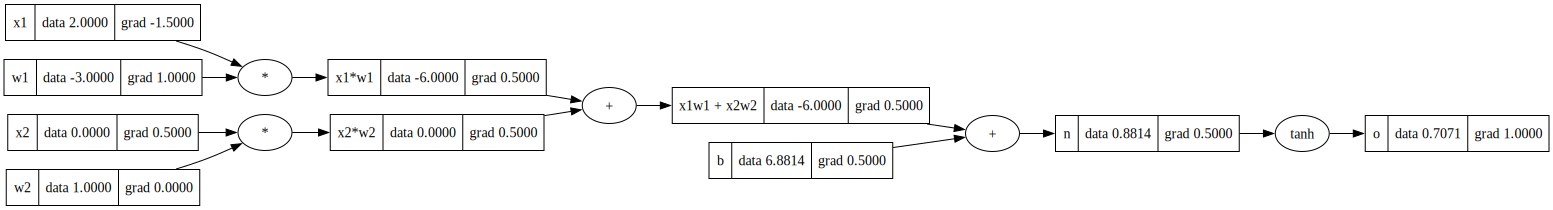

In [5]:
# inputs x1, x2 of 2D nueron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b of the nueron
b = Value(6.88137358, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

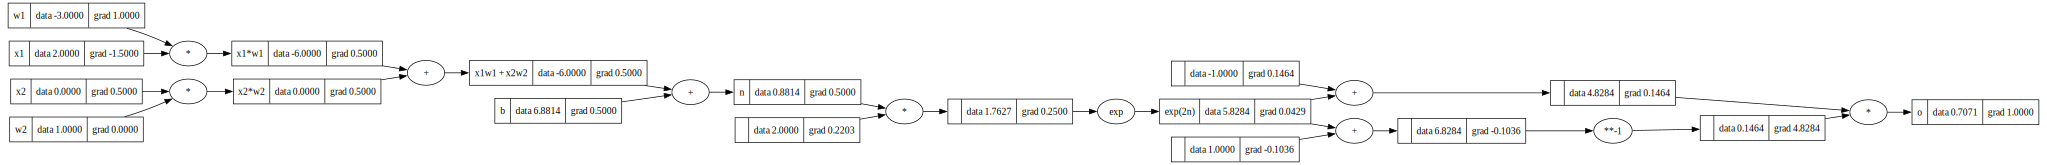

In [6]:
# inputs x1, x2 of 2D nueron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b of the nueron
b = Value(6.88137358, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
# --- now break down tanh(), expect same forward pass and backward, aka same values and gradients as when used tanh()
e = (2*n).exp()
e.label = 'exp(2n)'
o = (e - 1) / (e + 1)
o.label = 'o'
# ---
o.backward()

draw_dot(o)

In [7]:
"""
micrograd is roughly modeled after PyTorch
micrograd is a scalar valued engine, scalar values like 2.0

pytorch is modeled on tensors
"""
import torch

# note: tensor default type is float32, here we cast to doubles for a single precision float
# note: pytorch assumes by default that leaf nodes do not require gradients, this is for efficiency reasons, so we will set this to True explicitly
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137358]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)  # this is a tensor, with a data and grad attributes

# we call .item(), takes tensor of single item and strips the tensor
# o.item() and o.data.item() produce the same result in PyTorch
# o is a tensor object which also has a backward function
print(o.data.item())  
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [8]:
import random

class Neuron:

    def __init__(self, number_of_inputs):
        # a weight that is a random number btw -1 and 1 for every one of those inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(number_of_inputs)]
        # a bias that controls the overall trigger happiness of this neuron
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # this will be the forward pass of a single neuron
        # w * x + b where w * x is a dot product
        # zip takes 2 iterators and creates a new iterator
        # sum has a second optionl parameter to start adding on, default to 0; you could set this to self.b
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # pass the activation through a nonlinearity
        out = activation.tanh()
        return out
    
    # we want some convenience code to gather up all the parameters of the neural net,
    # and we can nudge them a tiny amount based on the grad informaton
    def parameters(self):
        # self.w is a list; list + list gives you a list
        # btw, pyTorch has a parameters on every neural network module
        return self.w + [self.b]
    
class Layer:

    # a layer is a list of neurons
    # number_of_inputs - how many neurons they layer has
    # number_of_outputs - how many neurons do you want
    def __init__(self, number_of_inputs, number_of_outputs):
        self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_outputs)]

    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            neuron_params = neuron.parameters()
            params.extend(neuron_params)
        return params

class MultiLayerPerceptron:
    
    # number_of_inputs - single value
    # list_of_number_of_outputs - list defining size of each layer in the MLP
    def __init__(self, number_of_inputs, list_of_number_of_outputs):
        sz = [number_of_inputs] + list_of_number_of_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(list_of_number_of_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
x = [2.0, 3.0, -1.0]  # 3 dimensional input
n = MultiLayerPerceptron(3, [4, 4, 1])  # 3 input and 2 layers of 4 and 1 output layer
print(n(x))
#draw_dot(n(x))
print(len(n.parameters()))

Value(data=-0.9566862198275301,grad=0.0)
41


In [10]:
n.parameters()  # all the weights and biases in the neural net, this has 41 of these parameters

[Value(data=0.8953142090649844,grad=0.0),
 Value(data=0.9519451612321272,grad=0.0),
 Value(data=-0.6866529779192645,grad=0.0),
 Value(data=0.12960400574497322,grad=0.0),
 Value(data=0.5994390396837892,grad=0.0),
 Value(data=-0.6479830519278709,grad=0.0),
 Value(data=0.3469812299370918,grad=0.0),
 Value(data=0.796294164835879,grad=0.0),
 Value(data=-0.5588295261445959,grad=0.0),
 Value(data=0.5993311073086451,grad=0.0),
 Value(data=-0.4848577464930879,grad=0.0),
 Value(data=-0.8137048731303294,grad=0.0),
 Value(data=-0.7760966904215085,grad=0.0),
 Value(data=0.860685297725807,grad=0.0),
 Value(data=0.08230199182425735,grad=0.0),
 Value(data=0.6551703583552975,grad=0.0),
 Value(data=0.03991932098453255,grad=0.0),
 Value(data=0.9365431716126764,grad=0.0),
 Value(data=-0.623681877206155,grad=0.0),
 Value(data=0.2686355078114986,grad=0.0),
 Value(data=-0.17371426295267267,grad=0.0),
 Value(data=0.9289224003318899,grad=0.0),
 Value(data=-0.8413796875681554,grad=0.0),
 Value(data=-0.421983454

In [11]:
# simple example dataset
# xs has 4 examples, aka 4 possible inputs into the neural net
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# this will be a simple binary classifier neural network
# first xs example [2.0, 3.0, -1.0] should result in 1.0, etc
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [12]:
# Step 1: Forward pass
ypred = [n(x) for x in xs]
print("ypred", ypred)  # this is the prediction given the 4 examples
# how do you tune the weights to better predict the desired targets?

# Calculate the loss
# we will use a single number to calculate the total performance of your neural net...this is the loss
# let's look at the mean squared error loss
# ygt = y ground truth
# we want to minimize the loss, this means that every target is close to prediction
# aka low loss means the predictions are matching the targets better
# the loss values are 0 only when yout is equal to y ground truth
losses = [(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]
loss = sum(losses)
print("loss", loss)

# this will have 4 forward passes of the neural net, and the loss on top, with the loss value at the very right
# xs are inputs to the neural net
# gradient values on input data are not that useful to us because the input data is not changeable, aka they are fixed inputs
# the weight and bias for each neuron in the neural net we do want to change, the gradients of those matter

# draw_dot(loss)

ypred [Value(data=-0.9566862198275301,grad=0.0), Value(data=-0.21562907841223622,grad=0.0), Value(data=-0.39584640264968907,grad=0.0), Value(data=-0.7635679201958355,grad=0.0)]
loss Value(data=7.919032083830574,grad=0.0)


In [13]:
# Step 2: Backward Pass
loss.backward()

In [14]:
# Step 3: Update - aka nudge
# we want to minimize the loss, aka decrease it
# the learning rate 0.01 here can be tricky, too low and it takes way too long to converge, too high and your loss may explode
# finding the step size to be just right is an art with vanilla gradient descent
for p in n.parameters():
    p.data += -0.01 * p.grad

In [15]:
# do this on a loop, this is gradient descent
ypred

[Value(data=-0.9566862198275301,grad=-3.91337243965506),
 Value(data=-0.21562907841223622,grad=1.5687418431755276),
 Value(data=-0.39584640264968907,grad=1.2083071947006219),
 Value(data=-0.7635679201958355,grad=-3.5271358403916713)]

In [16]:
# these are the weights and biases that makes our network preduct the desired targets very very close
n.parameters()

[Value(data=0.9043233918776344,grad=-0.9009182812650038),
 Value(data=0.9554887014508495,grad=-0.3543540218722243),
 Value(data=-0.6794370534426695,grad=-0.7215924476595019),
 Value(data=0.13735709218049616,grad=-0.7753086435522951),
 Value(data=0.6172116230279807,grad=-1.777258334419147),
 Value(data=-0.6302968146564193,grad=-1.7686237271451541),
 Value(data=0.32194969551837105,grad=2.5031534418720742),
 Value(data=0.8077503542033941,grad=-1.145618936751512),
 Value(data=-0.5607343228586033,grad=0.19047967140073363),
 Value(data=0.5966284914419239,grad=0.27026158667213035),
 Value(data=-0.48455667697410704,grad=-0.03010695189808206),
 Value(data=-0.8155393367400969,grad=0.18344636097675998),
 Value(data=-0.7769293268447366,grad=0.0832636423228061),
 Value(data=0.8599868913442803,grad=0.069840638152673),
 Value(data=0.08360406382778005,grad=-0.13020720035227),
 Value(data=0.6545637486179389,grad=0.06066097373585466),
 Value(data=0.04341325156602119,grad=-0.34939305814886396),
 Value(da

In [17]:
# init neural net
n = MultiLayerPerceptron(3, [4, 4, 1])  # 3 input and 2 layers of 4 and 1 output layer

# here's the data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [18]:
# let's put it all together - gradient descent

for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    # evaluate the loss
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
    # backward pass - don't forget to zero out the gradients of the parameters!!!
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update - simple stochastic gradient update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data, )


0 7.455137157187847
1 6.505744223686671
2 2.667190394830505
3 1.6186588396152035
4 0.826115013671846
5 0.5367589425723146
6 0.3989502359016883
7 0.3231805217451952
8 0.27038606275195526
9 0.2315967210535061
10 0.20204314160089143
11 0.17885756402140138
12 0.16022693645918268
13 0.14495580712859935
14 0.13222739361083366
15 0.12146641088856897
16 0.1122569094606764
17 0.10429121550341733
18 0.097337159786829
19 0.09121643881996767


In [19]:
ypred

[Value(data=0.8807573245543996,grad=-0.23848535089120082),
 Value(data=-0.7962795808144437,grad=0.40744083837111256),
 Value(data=-0.9341389220973427,grad=0.13172215580531454),
 Value(data=0.8234839032923507,grad=-0.3530321934152987)]

In [20]:
# neural nets are mathematical expressions that take inputs as data and inputs as weights
# the loss function measures the accuracy of predictions
# low loss means the network is doing what you want it to do
# then we do backprogation to get the gradients so we know how to tune the weights
# we follow the gradient information that minimizes the loss